In [1]:
%load_ext watermark
%watermark

2017-08-28T21:10:16+02:00

CPython 3.6.1
IPython 5.3.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams['font.size'] = 16

In [5]:
vehiculos = pd.read_csv("data/vehiculos_procesado.csv", 
                 usecols=["consumo", "co2", "cilindros","desplazamiento"])


litros_por_galon =  3.78541
vehiculos["consumo_litros_milla"] = litros_por_galon/ vehiculos.consumo



In [6]:
vehiculos.shape

(35539, 5)

In [7]:
vehiculos.head()

,desplazamiento,cilindros,consumo,co2,consumo_litros_milla
0,2.5,4.0,17,522.764706,0.222671
1,4.2,6.0,13,683.615385,0.291185
2,2.5,4.0,16,555.437500,0.236588
3,4.2,6.0,13,683.615385,0.291185
4,3.8,6.0,16,555.437500,0.236588


El modelo de regresión lineal mediante OLS (ordinary least squares) tiene la forma:

$$ \hat{y} = \alpha + \beta_{1}*x_{1} + \beta_{2}*x_{2} + ... + \beta_{n}*x_{n} + \varepsilon$$

Donde $\hat{y}$ es la predicción que queremos hacer,

$\alpha$ es el término independiente,

$\beta_{n}$ es un vector de coeficientes
y $x_{n}$ son los valores de las variables del dataset.

El objetivo es obtener $\alpha$ y $\beta_{n}$  tales que error cuadrático (residuo) , definido como:

$$RSS = \varepsilon² = \sum\limits_{i=1}^n(y_{i} - (\alpha - \beta_{i}x_{i}))^2$$

sea el mínimo.

Para ello tenemos que resolver las siguientes equaciones

$$\hat{\alpha} = \bar{y} - \hat{\beta}*\bar{x}$$
$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

Para obtener los coeficientes del modelo dedicamos una fracción del dataset a entrenar y otra a evaluar los resultados (para evitar sobreajuste o sobregeneralización)

In [8]:
pct_entrenamiento = 0.8

In [9]:
vehiculos_training = vehiculos.sample(frac=pct_entrenamiento)


vehiculos_test = vehiculos[~vehiculos.index.isin(vehiculos_training.index)]

print(vehiculos_training.shape)
print(vehiculos_test.shape)

(28431, 5)
(7108, 5)


In [10]:
variables_independientes = ['desplazamiento', 'cilindros','consumo_litros_milla']
variable_dependiente = 'co2'
X = vehiculos_training[variables_independientes].as_matrix()
y = vehiculos_training[variable_dependiente].as_matrix()
X_T = X.T

In [11]:
X

array([[ 2.2       ,  4.        ,  0.18025762],
       [ 5.2       ,  8.        ,  0.27038643],
       [ 4.6       ,  8.        ,  0.23658813],
       ..., 
       [ 1.6       ,  4.        ,  0.16458304],
       [ 3.1       ,  6.        ,  0.1892705 ],
       [ 5.5       ,  8.        ,  0.22267118]])

In [12]:
X.shape

(28431, 3)

In [13]:
y

array([ 423.19047619,  634.78571429,  555.4375    , ...,  386.39130435,
        444.35      ,  522.76470588])

In [14]:
betas = np.linalg.inv(X_T @ X) @ X_T @ y
betas

array([  3.79633118e+00,  -6.05631472e-01,   2.30563859e+03])

In [15]:
y.mean()

470.51918687853379

In [16]:
alfa = y.mean() - np.dot(betas,vehiculos_training[variables_independientes].mean().as_matrix())
alfa

0.36864623621659121

In [17]:
def predecir(r):
    return alfa + np.dot(betas, r.values)

In [18]:
vehiculos_training["co2_pred"] = vehiculos_training[variables_independientes].apply(
    predecir, axis=1)
vehiculos_test["co2_pred"] = vehiculos_test[variables_independientes].apply(predecir, axis=1)

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
vehiculos_training[["co2", "co2_pred"]].head()

,co2,co2_pred
8289,423.190476,421.906972
8969,634.785714,638.677901
11029,555.437500,558.473429
11703,683.615385,687.392043
29432,462.000000,469.758880


In [20]:
model_formula = "y ~ {alfa:.3f} + {beta_1:.2f}*desplazamiento + {beta_2:.2f}*cilindros + {beta_3:.3f}*consumo_litros_milla".format(
    alfa=alfa, beta_1=betas[0], beta_2=betas[1], beta_3=betas[2])
model_formula

'y ~ 0.369 + 3.80*desplazamiento + -0.61*cilindros + 2305.639*consumo_litros_milla'

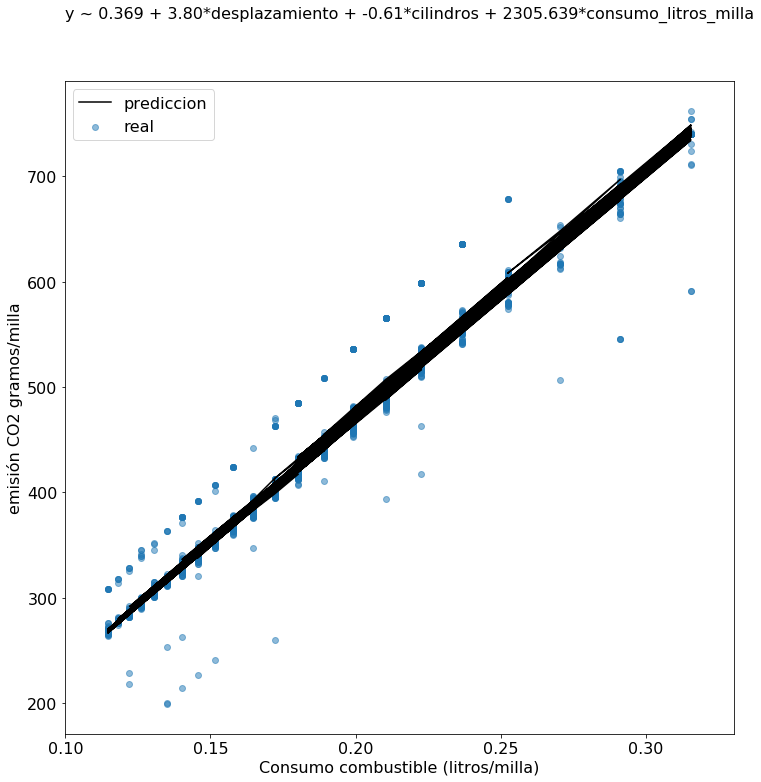

In [21]:
plt.scatter(vehiculos_test.consumo_litros_milla, vehiculos_test.co2, alpha=0.5, label="real")
plt.text(0.1, 850, model_formula)
plt.plot(vehiculos_test.consumo_litros_milla,vehiculos_test.co2_pred, c="black", label="prediccion")
plt.xlabel("Consumo combustible (litros/milla)")
plt.ylabel("emisión CO2 gramos/milla")
plt.legend();

In [22]:
def error_cuadrático_medio(y, y_pred):
    return np.sum((y-y_pred)**2)/len(y)

In [23]:
error_training = error_cuadrático_medio(vehiculos_training.co2, vehiculos_training.co2_pred)
error_training

132.38686796110582

In [24]:
error_test = error_cuadrático_medio(vehiculos_test.co2, vehiculos_test.co2_pred)
error_test

127.01291590394035

### Links

http://people.revoledu.com/kardi/tutorial/Regression/OLS.html

http://setosa.io/ev/ordinary-least-squares-regression/